# Natural Images Dataset

## Autores
Desenvolvido por **Eduardo Graf** e **Nathan Wagner**

## Link da apresentação (ppt e vídeo)

* PowerPoint: https://docs.google.com/presentation/d/1EZpAVWzgcqZwnqM_75O9kWWGz4wxNDaKtP3M-WF3EZA/edit?usp=sharing
* Vídeo de apresentação: https://asavbrm-my.sharepoint.com/:v:/g/personal/nwagner_edu_unisinos_br/IQDechTmJRoaRLTYWUtNHm0HAYH6Iv3s4mUgiU_S9yNvxSA?e=4iCvw0

## Link do dataset (Kaggle)

<a href="https://www.kaggle.com/datasets/prasunroy/natural-images" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>
<br> <br>
Este conjunto de dados contém 6.899 imagens de 8 classes distintas, compiladas a partir de diversas fontes. As classes incluem avião, carro, gato, cachorro, flor, fruta, motocicleta e pessoa.

## Objetivo

O objetivo deste código é construir e treinar uma Rede Neural Convolucional (CNN) capaz de classificar imagens automaticamente em 8 categorias distintas.

## 1. Importações

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## 2. Estilos de gráficos

* **Estilo Visual**: Configura o matplotlib para usar o estilo ```seaborn-v0_8``` e escolhe a paleta de cores husl, mostrando gráficos mais legíveis e agradáveis.

* **Seeds**: Define sementes (_seeds_) fixas para os geradores de números aleatórios do ```TensorFlow``` e do ```NumPy```.

In [65]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
tf.random.set_seed(42)
np.random.seed(42)

## 3. Mapeamento dos Arquivos de Imagem

Este trecho percorre o diretório ```./natural_images```. O objetivo é coletar o caminho completo de todos os arquivos encontrados nas subpastas e armazená-los na lista ```images```, permitindo uma contagem inicial do volume de dados.

In [66]:
images_folder_path = './natural_images'

images = []

for dirname, _, filenames in os.walk(images_folder_path):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))

In [67]:
print(f"Number of images: {len(images)}")

Number of images: 6899


In [68]:
class_names = os.listdir(images_folder_path)
print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


## 4. Contagem de Distribuição das Classes

Percorre cada categoria identificada e conta quantos arquivos existem em sua respectiva subpasta. Os totais são armazenados no dicionário ```class_counts```. Esta etapa é fundamental para verificar o **balanceamento do dataset**.

In [69]:
class_counts = {}
for class_name in class_names:
    class_counts[class_name] = len(os.listdir(os.path.join(images_folder_path, class_name)))

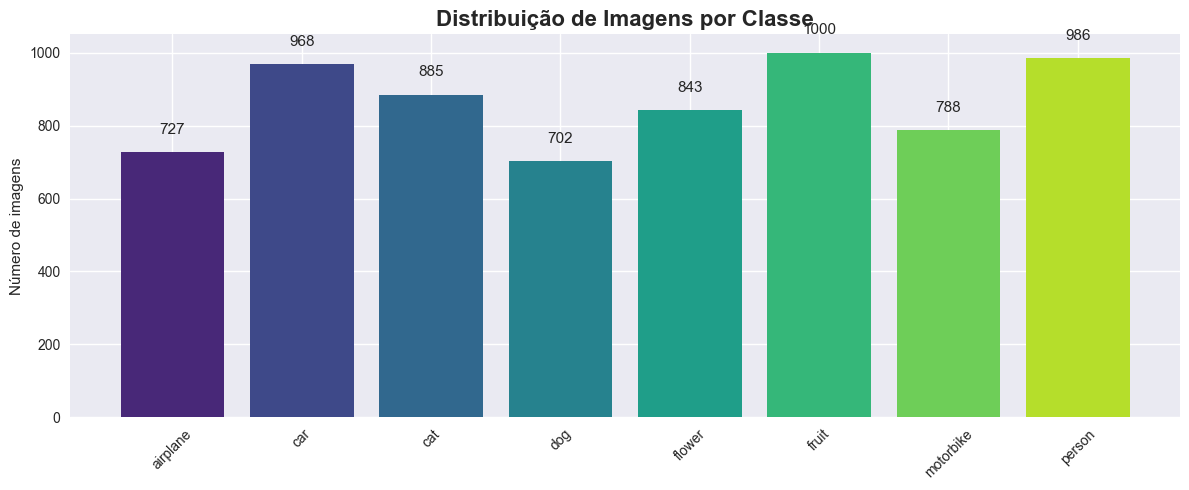

In [70]:
plt.figure(figsize=(12, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=sns.color_palette("viridis", 8))
plt.title('Distribuição de Imagens por Classe', fontsize=16, fontweight='bold')
plt.ylabel('Número de imagens')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', fontsize=11)
plt.tight_layout()
plt.show()

## 5. Visualização de Amostras Aleatórias

Este bloco gera um grid $4 \times 4$ exibindo 16 imagens selecionadas aleatoriamente do dataset. O objetivo é permitir uma visualização das diferentes classes.

* As imagens são carregadas e redimensionadas para $150 \times 150$ pixels para padronizar a exibição.

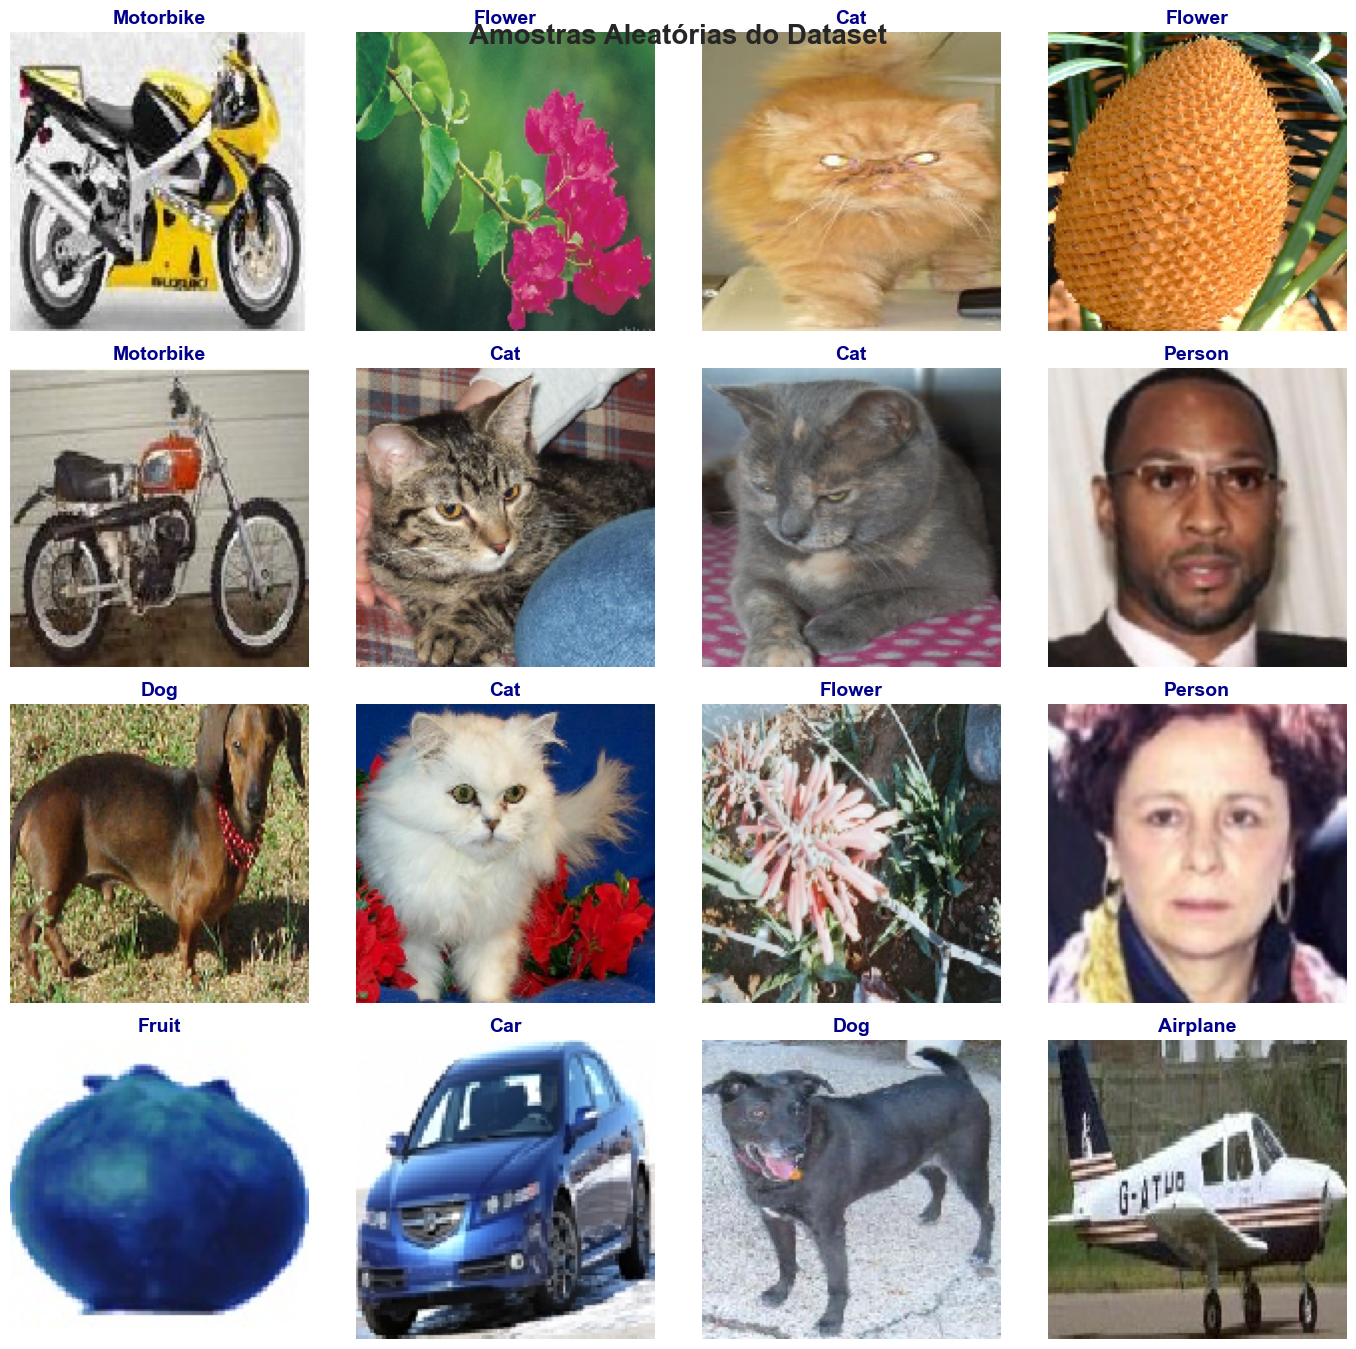

In [71]:
plt.figure(figsize=(14, 14))
for i in range(16):
    cls = np.random.choice(class_names)
    cls_dir = os.path.join(images_folder_path, cls)
    img_name = np.random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_name)
    img = load_img(img_path, target_size=(150, 150))
    
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(cls.replace('_', ' ').title(), fontsize=14, fontweight='bold', color='darkblue')
    plt.axis('off')
plt.suptitle('Amostras Aleatórias do Dataset', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

## 6. Pré-Processamento e Data Augmentation

É configurado o ```ImageDataGenerator``` com três objetivos principais:

1. **Padronização (Normalização)**: Convertemos os valores das cores dos pixels (que variam de 0 a 255) para uma escala entre 0 e 1, facilitando a convergência da rede neural.

2. **Data Augmentation (Aumento de Dados)**: O código gera automaticamente variações das imagens de treino (gira, dá zoom, inverte horizontalmente). Isso aumenta artificialmente a diversidade do dataset e ajuda a prevenir _overfitting_.

3. **Carregamento (Flow)**: Cria os geradores ```train_data``` (80%) e ```val_data``` (20%), que carregam as imagens em lotes e as redimensionam para $150 \times 150$.

In [72]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    images_folder_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_data = datagen.flow_from_directory(
    images_folder_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


## 7. Definição da Arquitetura CNN

Este bloco monta uma Rede Neural Convolucional (CNN) robusta e profunda para extração de características e classificação:

* **Extração de Features (Convolução)**: Utiliza 4 blocos de camadas ```Conv2D``` (aumentando de 32 para 256 filtros) alternadas com ```MaxPooling2D``` para reduzir a dimensionalidade.

* Estabilização e Regularização:

    * **BatchNormalization**: Normaliza as ativações internas, acelerando o treinamento e estabilizando a rede.

    * **Dropout (0.5 e 0.3)**: Desativa aleatoriamente neurônios durante o treino para evitar superajuste (_overfitting_).

* **Classificação**: As camadas ```Dense``` finais processam as features achatadas (```Flatten```). A camada de saída possui 8 neurônios com ativação ```softmax```, retornando a probabilidade para cada uma das 8 classes.

* **Compilação**: O modelo é compilado com o otimizador ```Adam``` (taxa de aprendizado 0.001) e função de perda ```categorical_crossentropy```.

![](./licensed-image.jfif)

In [73]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                      

## 8. CallBacks

Definição de funções de controle executadas durante o treinamento para otimizar o aprendizado e salvar o melhor estado do modelo:

* **EarlyStopping**: Interrompe o treinamento prematuramente se a acurácia de validação não melhorar após 8 épocas (```patience=8```), restaurando os melhores pesos encontrados. Isso economiza tempo e evita overfitting.

* **ModelCheckpoint**: Salva o modelo no arquivo ```best_model_natural.keras``` apenas quando há uma melhoria na acurácia de validação, garantindo que a melhor versão seja preservada.

* **ReduceLROnPlateau**: Reduz a taxa de aprendizado (_learning rate_) pela metade (```factor=0.5```) se a perda de validação estagnar por 4 épocas, permitindo ajustes mais finos nos pesos quando o modelo encontra um platô.

In [74]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model_natural.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

## 9. Treinamento

* **Alimentação**: O modelo recebe os batches de treino e é avaliado contra os dados de validação ao final de cada ciclo.

* **Duração**: Configurado para rodar por até 50 épocas, mas a execução é supervisionada pelos callbacks (EarlyStopping), que podem interromper o processo antes caso o modelo pare de evoluir ou comece a sofrer overfitting.

* **Registro**: O objeto history armazena as métricas (perda e acurácia) passo a passo, dados essenciais para a análise gráfica posterior.

In [75]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
173/173 [==============================] - ETA: 0s - loss: 1.1868 - accuracy: 0.6307
Epoch 1: val_accuracy improved from -inf to 0.18010, saving model to best_model_natural.keras
173/173 [==============================] - 245s 1s/step - loss: 1.1868 - accuracy: 0.6307 - val_loss: 4.8475 - val_accuracy: 0.1801 - lr: 0.0010
Epoch 2/50
173/173 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.7450
Epoch 2: val_accuracy improved from 0.18010 to 0.37037, saving model to best_model_natural.keras
173/173 [==============================] - 252s 1s/step - loss: 0.7763 - accuracy: 0.7450 - val_loss: 2.8067 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 3/50
173/173 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7805
Epoch 3: val_accuracy improved from 0.37037 to 0.62019, saving model to best_model_natural.keras
173/173 [==============================] - 242s 1s/step - loss: 0.6244 - accuracy: 0.7805 - val_loss: 1.1808 - val_accuracy: 0.6202 - 

## 10. Visualizações Pós-Treinamento

Este bloco gera dois gráficos comparativos para avaliar o desempenho do modelo ao longo das épocas:

* **Acurácia (Esquerda)**: Monitora o quanto o modelo está acertando. O ideal é que ambas as curvas (Treino e Validação) cresçam e se mantenham próximas.

* **Perda/Loss (Direita)**: Monitora o erro do modelo. O objetivo é que ambas as curvas decresçam até estabilizar.

* **Diagnóstico**: A visualização simultânea das curvas de Treino (Azul) e Validação (Vermelho) permite identificar rapidamente problemas como _overfitting_ (quando o erro de validação começa a subir enquanto o de treino continua caindo).

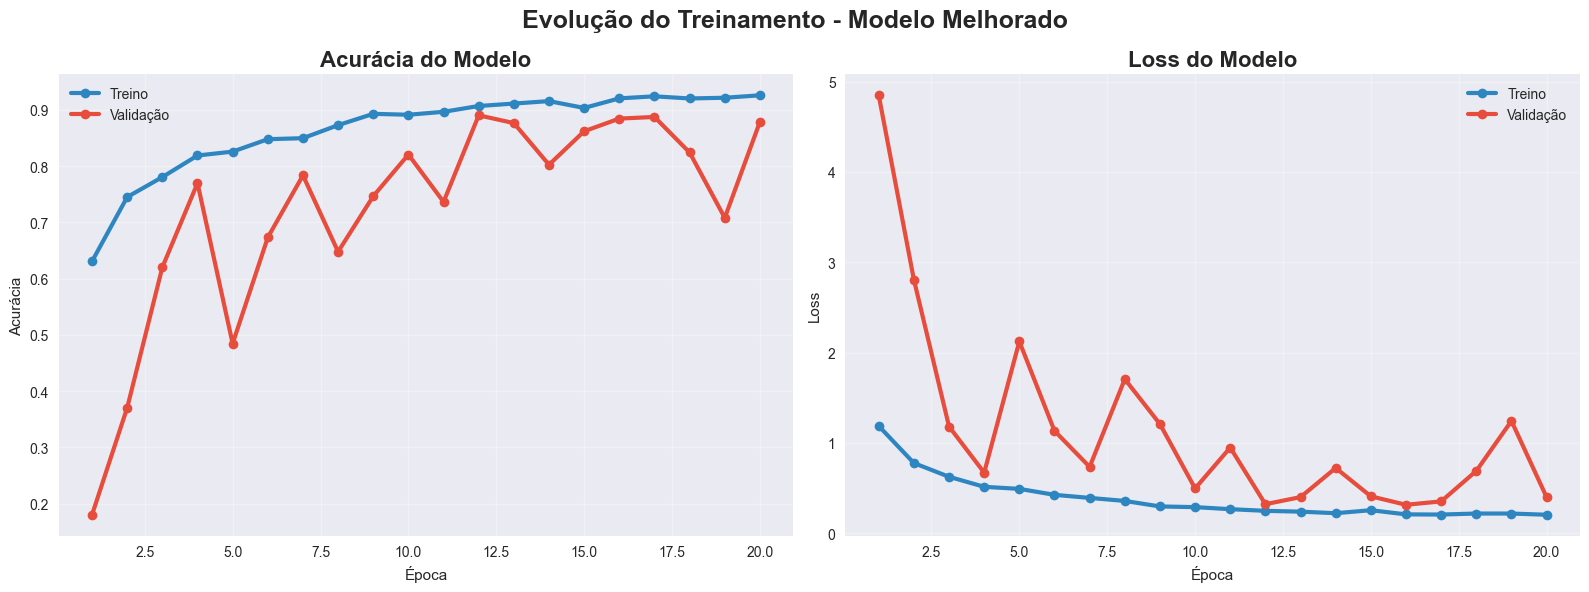

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, len(history.history['accuracy']) + 1)

ax1.plot(epochs, history.history['accuracy'], 'o-', linewidth=3, label='Treino', color='#2E86C1')
ax1.plot(epochs, history.history['val_accuracy'], 'o-', linewidth=3, label='Validação', color='#E74C3C')
ax1.set_title('Acurácia do Modelo', fontsize=16, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history.history['loss'], 'o-', linewidth=3, label='Treino', color='#2E86C1')
ax2.plot(epochs, history.history['val_loss'], 'o-', linewidth=3, label='Validação', color='#E74C3C')
ax2.set_title('Loss do Modelo', fontsize=16, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Evolução do Treinamento', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Avaliação Final + Matriz de Confusão

Este bloco finaliza o ciclo de análise carregando explicitamente a melhor versão do modelo salva (```best_model_natural.keras```) para garantir o uso dos pesos otimizados, e não necessariamente os da última época.

* **Precision**: A precisão dos acertos positivos.

* **Recall**: A capacidade de encontrar todas as instâncias positivas.

* **F1-Score**: A média harmônica entre Precision e Recall.

In [ ]:
best_model = history.model

val_data.reset()

predictions = best_model.predict(val_data, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes

print("\n" + "="*70)
print(" CLASSIFICATION REPORT - MELHOR MODELO ".center(70, "="))
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


=============== CLASSIFICATION REPORT - MELHOR MODELO ================
              precision    recall  f1-score   support

    airplane     0.9273    0.7034    0.8000       145
         car     0.9109    0.9534    0.9316       193
         cat     0.8357    0.6610    0.7382       177
         dog     0.6158    0.7786    0.6877       140
      flower     0.8939    0.9524    0.9222       168
       fruit     0.9949    0.9750    0.9848       200
   motorbike     0.8895    0.9745    0.9301       157
      person     0.9652    0.9848    0.9749       197

    accuracy                         0.8816      1377
   macro avg     0.8791    0.8729    0.8712      1377
weighted avg     0.8884    0.8816    0.8807      1377



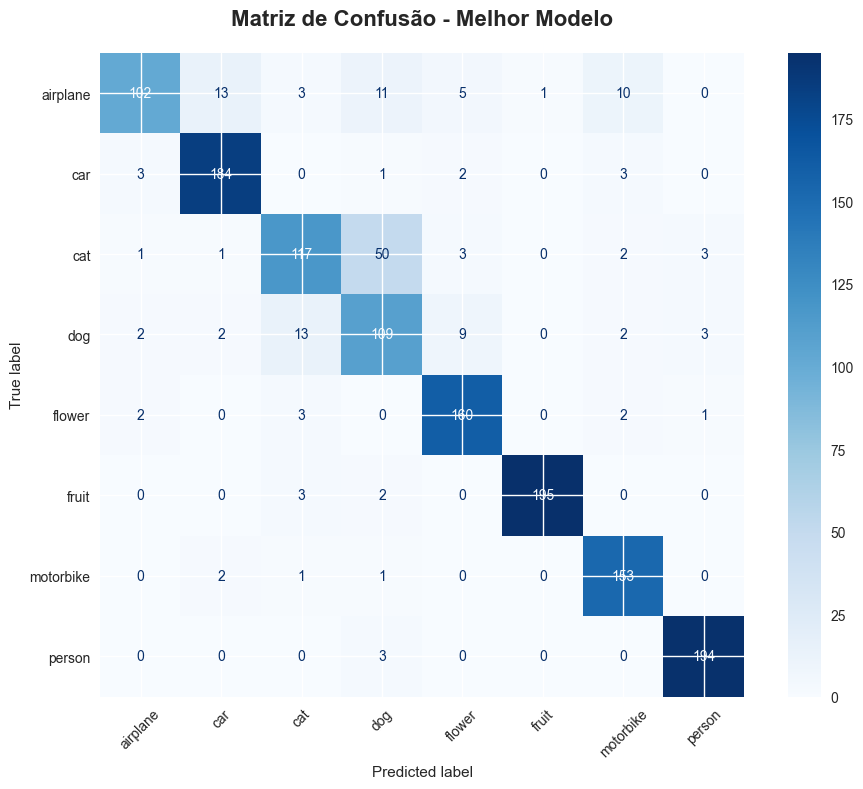


Acurácia final no conjunto de validação (melhor modelo): 88.53%


In [93]:
# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
plt.title('Matriz de Confusão - Melhor Modelo', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Acurácia final
loss, acc = best_model.evaluate(val_data, verbose=0)
print(f"\nAcurácia final no conjunto de validação (melhor modelo): {acc*100:.2f}%")

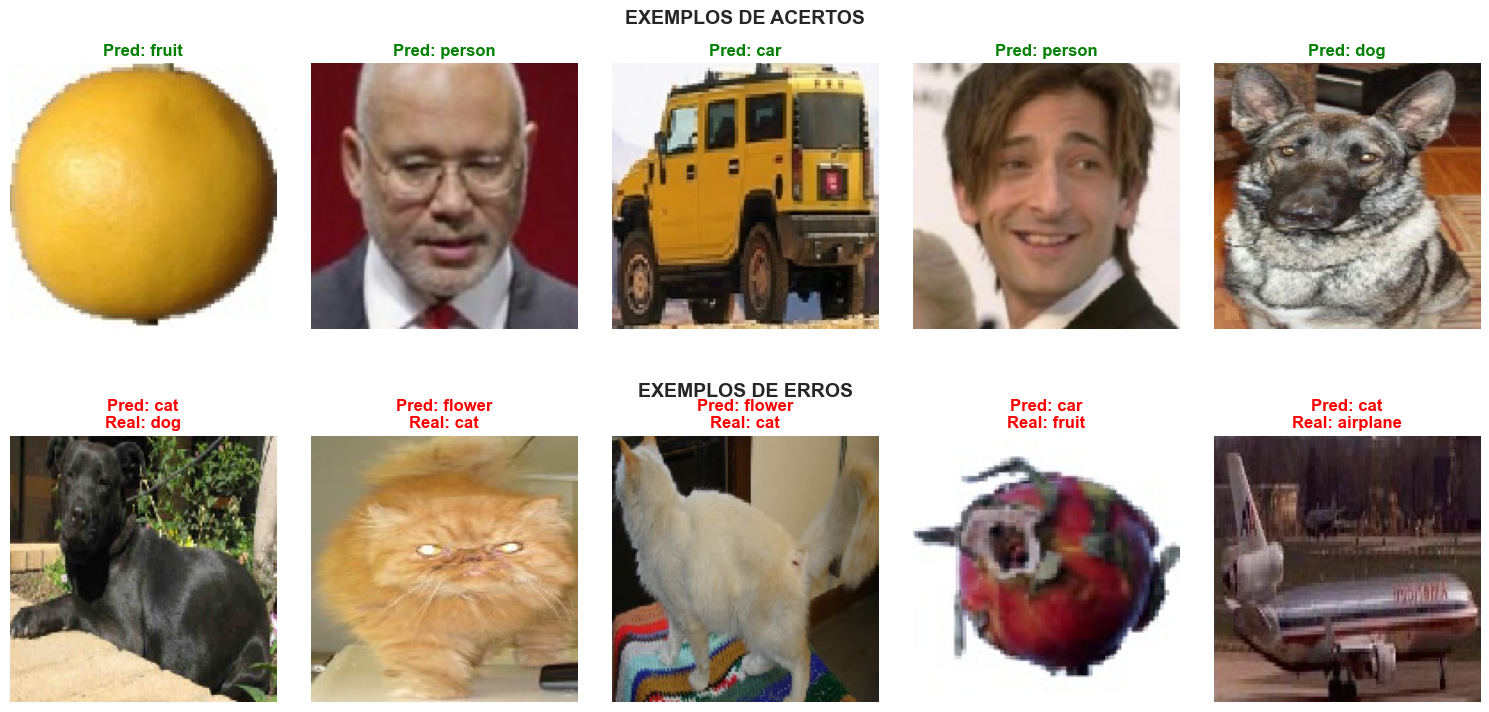

Total de acertos: 1214
Total de erros: 163


In [ ]:
val_data.reset()
predictions = best_model.predict(val_data, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes

correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

plt.figure(figsize=(15, 8))

# Se houver menos de 5 acertos, pega o total disponível
num_correct = min(5, len(correct_indices))
if num_correct > 0:
    # Escolhe índices aleatórios sem repetição
    chosen_correct = np.random.choice(correct_indices, num_correct, replace=False)
    
    for i, idx in enumerate(chosen_correct):
        plt.subplot(2, 5, i + 1)
        # Carrega a imagem original pelo caminho salvo no gerador
        img_path = val_data.filepaths[idx]
        img = load_img(img_path, target_size=(150, 150))
        
        plt.imshow(img)
        plt.title(f"Pred: {class_names[y_pred[idx]]}", color='green', fontweight='bold')
        plt.axis('off')
        if i == 2: plt.text(0.5, 1.15, "EXEMPLOS DE ACERTOS", 
                            transform=plt.gca().transAxes, ha='center', fontsize=14, fontweight='bold')
        
num_incorrect = min(5, len(incorrect_indices))
if num_incorrect > 0:
    chosen_incorrect = np.random.choice(incorrect_indices, num_incorrect, replace=False)
    
    for i, idx in enumerate(chosen_incorrect):
        plt.subplot(2, 5, i + 6) # Pula para a segunda linha (índices 6 a 10)
        img_path = val_data.filepaths[idx]
        img = load_img(img_path, target_size=(150, 150))
        
        plt.imshow(img)
        # Mostra o que ele previu (Errado) e o que era de verdade (Real)
        plt.title(f"Pred: {class_names[y_pred[idx]]}\nReal: {class_names[y_true[idx]]}", 
                  color='red', fontweight='bold')
        plt.axis('off')
        if i == 2: plt.text(0.5, 1.15, "EXEMPLOS DE ERROS", 
                            transform=plt.gca().transAxes, ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total de acertos: {len(correct_indices)}")
print(f"Total de erros: {len(incorrect_indices)}")